#init block

In [ ]:
#@title git clone & modules install { form-width: "123px" }

! rm -rf lib_temp/
! git clone https://github.com/nikolayilyin/python_tools.git lib_temp
! ls lib_temp
! pip install boto3

from lib_temp.tools.library import *
from lib_temp.tools import dashboard

%matplotlib inline
# Main Python imports and params for Mathplotlib
from datetime import datetime, timedelta

import os
import matplotlib as mpl
#if os.environ.get('DISPLAY','') == '':
    #print('no display found. Using non-interactive Agg backend')
    #mpl.use('Agg')

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import datetime as dt

from numpy.random import rand
from matplotlib import colors
from matplotlib import cm

import time
import traceback
import urllib
import re
import statistics

pd.set_option('display.precision',12)

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from io import StringIO

from urllib.error import HTTPError

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

# You can reduce this if plots are too big
# global_figsize = [30, 15]
# global_imgsize = [30, 30]
# plt.rcParams['figure.figsize'] = global_figsize

# You can reduce this if plots are too big
plt.rcParams['figure.figsize'] = [16, 12]

# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 14}

font = {'size': 14}
mpl.rc('font', **font)

from IPython.core.display import display, HTML
from IPython.display import Image

display(HTML("<style>.container { width:95% !important; }</style>"))

def plot_calibration_parameters(title_to_s3url,
                                suptitle="", figsize=(23, 6), rot=70,
                                calibration_parameters=None,
                                removal_probabilities=None):
    if calibration_parameters is None:
        calibration_parameters = ['additional_trip_utility', 'walk_transit_intercept']

    calibration_values = []

    for (title, s3url) in title_to_s3url:
        s3path = get_output_path_from_s3_url(s3url)
        config = parse_config(s3path + "/fullBeamConfig.conf", complain=False)

        def get_config_value(conf_value_name):
            return config.get(conf_value_name, '=default').split('=')[-1]

        param_values = [title]
        for param in calibration_parameters:
            param_value = get_config_value(param)
            param_values.append(float(param_value))

        calibration_values.append(param_values)

    calibration_parameters.insert(0, 'name')
    result = pd.DataFrame(calibration_values, columns=calibration_parameters)

    linewidth = 4
    removal_probabilities_color = 'green'

    ax = result.plot(x='name', figsize=figsize, rot=rot, linewidth=linewidth)

    # for (idx, params) in zip(range(len(calibration_values)), calibration_values):
    #     for param in params[1:]:
    #         plt.annotate(param, (idx, param))  # , textcoords="offset points", xytext=(0,10), ha='center')

    if removal_probabilities:
        ax.plot(np.NaN, label='removal probabilities (right scale)',
                color=removal_probabilities_color, linewidth=linewidth)

    ax.set_title('calibration parameters {}'.format(suptitle))
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.grid('on', which='major', axis='y')

    if removal_probabilities:
        ax2 = ax.twinx()
        ax2.plot(range(len(removal_probabilities)), removal_probabilities,
                 color=removal_probabilities_color, alpha=0.5, linewidth=linewidth)


def parse_config(config_url, complain=True):
    config = urllib.request.urlopen(config_url)

    config_keys = ["flowCapacityFactor", "speedScalingFactor", "quick_fix_minCarSpeedInMetersPerSecond",
                   "activitySimEnabled", "transitCapacity",
                   "minimumRoadSpeedInMetersPerSecond", "fractionOfInitialVehicleFleet",
                   "agentSampleSizeAsFractionOfPopulation",
                   "simulationName", "directory", "generate_secondary_activities", "lastIteration",
                   "fractionOfPeopleWithBicycle",
                   "parkingStallCountScalingFactor", "parkingPriceMultiplier", "parkingCostScalingFactor", "queryDate",
                   "transitPrice", "transit_crowding", "transit_crowding_percentile",
                   "maxLinkLengthToApplySpeedScalingFactor", "max_destination_distance_meters",
                   "max_destination_choice_set_size",
                   "transit_crowding_VOT_multiplier", "transit_crowding_VOT_threshold",
                   "activity_file_path", "intercept_file_path", "additional_trip_utility",
                   "ModuleProbability_1", "ModuleProbability_2", "ModuleProbability_3", "ModuleProbability_4",
                   "BUS-DEFAULT","RAIL-DEFAULT","SUBWAY-DEFAULT"]
    intercept_keys = ["bike_intercept", "car_intercept", "drive_transit_intercept", "ride_hail_intercept",
                      "ride_hail_pooled_intercept", "ride_hail_transit_intercept", "walk_intercept",
                      "walk_transit_intercept", "transfer"]

    config_map = {}
    default_value = ""

    for conf_key in config_keys:
        config_map[conf_key] = default_value

    def set_value(key, line_value):
        value = line_value.strip().replace("\"", "")

        if key not in config_map:
            config_map[key] = value
        else:
            old_val = config_map[key]
            if old_val == default_value or old_val.strip() == value.strip():
                config_map[key] = value
            else:
                if complain:
                    print("an attempt to rewrite config value with key:", key)
                    print("   value in the map  \t", old_val)
                    print("   new rejected value\t", value)

    physsim_names = ['JDEQSim', 'BPRSim', 'PARBPRSim', 'CCHRoutingAssignment']

    def look_for_physsim_type(config_line):
        for physsim_name in physsim_names:
            if 'name={}'.format(physsim_name) in config_line:
                set_value("physsim_type", "physsim_type = {}".format(physsim_name))

    for b_line in config.readlines():
        line = b_line.decode("utf-8").strip()

        look_for_physsim_type(line)

        for ckey in config_keys:
            if ckey + "=" in line or ckey + "\"=" in line:
                set_value(ckey, line)

        for ikey in intercept_keys:
            if ikey in line:
                set_value(ikey, line)

    return config_map


def plot_modechoice_comparison(title_to_s3url, benchmark_url, benchmark_name="benchmark", iteration=0,
                               do_fake_walk_analysis=False, fake_walkers=None):
    modes = ['bike', 'car', 'drive_transit', 'ride_hail',
             'ride_hail_pooled', 'ride_hail_transit', 'walk_transit', 'walk']

    if do_fake_walk_analysis:
        modes = modes + ['walk_fake', 'walk_real']

    def get_realized_modes(s3url, data_file_name='realizedModeChoice.csv', fake_walkers_dict=None):
        path = get_output_path_from_s3_url(s3url) + "/" + data_file_name
        df = pd.read_csv(path)
        tail = df.tail(1).copy()

        exist_columns = set(tail.columns)
        for m in modes:
            if m not in exist_columns:
                tail[m] = 0.0
            else:
                tail[m] = tail[m].astype(float)

        if do_fake_walk_analysis:
            fake_walkers_current = None
            if fake_walkers_dict:
                fake_walkers_current = fake_walkers_dict.get(s3url)
            if not fake_walkers_current:
                fake_walkers_current = analyze_fake_walkers(s3url, iteration, threshold=2000, title="", modechoice=None)

            walk_real_perc = fake_walkers_current[1]
            walk_fake_perc = fake_walkers_current[3]

            total_perc = walk_real_perc + walk_fake_perc
            one_perc_of_walk = int(tail['walk']) / total_perc

            print("walk: {} 1%: {} walk_real: {} walk_fake: {}".format(
                int(tail['walk']), one_perc_of_walk,
                one_perc_of_walk * walk_real_perc,
                one_perc_of_walk * walk_fake_perc))

            tail['walk_real'] = one_perc_of_walk * walk_real_perc
            tail['walk_fake'] = one_perc_of_walk * walk_fake_perc

        return tail[modes]

    benchmark = get_realized_modes(benchmark_url, fake_walkers_dict=fake_walkers).reset_index(drop=True)

    benchmark_absolute = benchmark.copy()
    benchmark_absolute['name'] = benchmark_name

    zeros = benchmark_absolute.copy()
    for mode in modes:
        zeros[mode] = 0.0

    modechoices_absolute = [benchmark_absolute]
    modechoices_difference = [zeros]
    modechoices_diff_in_percentage = [zeros]

    for (name, url) in title_to_s3url:
        modechoice = get_realized_modes(url, fake_walkers_dict=fake_walkers).reset_index(drop=True)

        modechoice_absolute = modechoice.copy()
        modechoice_absolute['name'] = name
        modechoices_absolute.append(modechoice_absolute)

        modechoice = modechoice.sub(benchmark, fill_value=0)
        modechoice_perc = modechoice / benchmark * 100

        modechoice['name'] = name
        modechoices_difference.append(modechoice)

        modechoice_perc['name'] = name
        modechoices_diff_in_percentage.append(modechoice_perc)

    df_absolute = pd.concat(modechoices_absolute)
    df_diff = pd.concat(modechoices_difference)
    df_diff_perc = pd.concat(modechoices_diff_in_percentage)

    _, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex='all', figsize=(20, 5 * 3))

    def plot(df, ax, title):
        df.set_index('name').plot(kind='bar', ax=ax, rot=65)
        ax.axhline(0, color='black', linewidth=0.4)
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        ax.set_title(title)

    plot(df_absolute, ax0, "absolute values of modechoice")
    plot(df_diff, ax1, "difference between run and benchmark in absolute numbers")
    plot(df_diff_perc, ax2, "difference between run and benchmark in percentage")

    plt.suptitle("BEAM run vs benchmark. realizedModeChoice.csv")



###
###
###
###   specific analysis for beam runs
###
###
###


# s3 urls into title based on config values

# title_to_s3url = []

# for s3url in s3urls:
#   s3path = get_output_path_from_s3_url(s3url)
#   config = parse_config(s3path + "/fullBeamConfig.conf", complain=False)
      
#   def get_config_value(conf_value_name):
#     return config.get(conf_value_name, '=default').split('=')[-1]

#   additional_trip_utility = get_config_value('additional_trip_utility')
#   transit_crowding_VOT_threshold = get_config_value("transit_crowding_VOT_threshold")
#   transit_crowding_VOT_multiplier = get_config_value("transit_crowding_VOT_multiplier")
#   simulationName = get_config_value("simulationName").split('/')[-1].split('__')[0].split('new-york-200k-industry-')[-1]

#   if transit_crowding_VOT_multiplier == 0 or transit_crowding_VOT_multiplier == '0':
#     title = "{}, trip util:{}".format(simulationName, additional_trip_utility)
#   else:
#     title = "{}, trip util:{}\ncrowding VOT threshold: {} multiplier: {}".format(simulationName, 
#                                                                                   additional_trip_utility, 
#                                                                                   transit_crowding_VOT_threshold,
#                                                                                   transit_crowding_VOT_multiplier)
#   title_to_s3url.append((title, s3url))
# title_to_s3url.sort()

def analyze_single_run(s3url, name, iteration=10):

  calibration_texts = []
  s3path = get_output_path_from_s3_url(s3url)    

  _, axs = plt.subplots(2, 2, sharex=True, figsize=(25, 10))
  plt.suptitle(name)

  plot_activities_ends_vs_bench(s3url, iteration=iteration, ax=axs[0,0], ax2=axs[0,1], title="Activities ends comparison", population_size=population_size)
  plot_simulation_volumes_vs_bench(s3url, iteration=iteration, ax=axs[1,0], title="Volume SUM comparison with benchmark.")  

  # plot_simulation_vs_google_speed_comparison(s3url, iteration=iteration, compare_vs_3am = False)

  get_calibration_png_graphs(s3url, first_iteration=0, last_iteration=iteration, png_title = name)

  main_text = get_calibration_text_data(s3url, commit=baseline_commit)
  fake_walkers = analyze_fake_walkers(s3url=s3url, iteration=iteration, threshold=2000, title=name, modechoice = None)

  replanning_path = s3path + "/ITERS/it.{0}/{0}.replanningEventReason.csv".format(iteration)
  replanning_reasons = pd.read_csv(replanning_path)
  print('\nreplanning_reasons:\n',replanning_reasons,'\n\n')
  walk_transit_exhausted = replanning_reasons[replanning_reasons['ReplanningReason'] == 'ResourceCapacityExhausted WALK_TRANSIT']['Count'].values[0]

  calibration_texts.append((main_text, fake_walkers, walk_transit_exhausted))

  print("\n\n\n")

  print("\n\n MAIN TEXT to copy-paste:")
  for (text,_,_) in calibration_texts:
    print(text)

  print("\n FAKE WALKERS (real, real%, fake, fake%, all modechoices):")
  for (_,fake_walkers,_) in calibration_texts:
    print(fake_walkers)

  print("\n ResourceCapacityExhausted WALK_TRANSIT:")
  for (_,_,walk_transit_exhausted) in calibration_texts:
    print(walk_transit_exhausted)

  print("\n")


print("code block initialized")


Cloning into 'lib_temp'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (312/312), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 312 (delta 187), reused 226 (delta 111), pack-reused 0
Receiving objects: 100% (312/312), 71.50 KiB | 5.96 MiB/s, done.
Resolving deltas: 100% (187/187), done.
dashboard  events  README.md  routing  setup.py  tools
initialized


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


code block initialized


# The scripts

In [ ]:
#@title data source { form-width: "123px" }

s3url = "https://s3.us-east-2.amazonaws.com/beam-outputs/index.html#output/newyork/NYC-doublerouter-baseline-bus-vs-subway-2__2020-10-07_17-00-02_bvy"
iteration = 10


In [ ]:
#@title subway scatter scripts

from lib_temp.tools.events import *
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math

# It needs events with PathTraversalEvents for subway and all the PersonEntersVehicle events
def subway_entries(events):
  pev = events[(events['type'] == 'PersonEntersVehicle')].copy()
  pev['prev_vehicle'] = pev.groupby('person')['vehicle'].shift(1)
  pev = pev[(pev['vehicle'].str.contains('Subway')) & (~pev['prev_vehicle'].str.contains('Subway', na=False)) & (~pev['person'].str.startswith('TransitDriverAgent', na=False))]
  entries = pev.groupby(['vehicle', 'time'])['person'].count()
  entries.name = 'entries'
  return entries

# generates a DF with the station coords and num of entries
def to_entries_on_station(s3url, iteration):
  events = load_events_from_s3_chunked(s3url, iteration, lambda df: ((df['type'] == 'PathTraversal') & (df['mode'] == 'subway')) | (df['type'] == 'PersonEntersVehicle')) 
  entries = subway_entries(events)
  pte = events[(events['type'] == 'PathTraversal')]

  #pte with entries
  ptee = pd.merge(pte, entries, how='left', left_on=['vehicle', 'departureTime'], right_on=['vehicle', 'time'])
  ptee['entries'].fillna(0, inplace=True)
  #entries on stations
  ent = ptee.groupby(['startX', 'startY'])['entries'].sum()
  return ent

def subway_mta_comparison(entries, name):
  #Loads MTA data from Zach. This is pretty quick but can be set as a param if required
  mta = pd.read_csv("https://beam-outputs.s3.amazonaws.com/new_city/newyork/lat-lon-station-counts.csv.gz")

  def map_mta(entries, mta):
    mta_stations = mta[['Origin Station', 'Origin Station_Lat', 'Origin Station_Lon', 'Total']].copy()
    mta_stations = mta.rename(columns={'Origin Station': 'Name', 'Origin Station_Lat': 'startY', 'Origin Station_Lon': 'startX'})

    def squared_distance(a, b):
      dx = a['startX'] - b['startX']
      dy = a['startY'] - b['startY']
      return dx * dx + dy * dy

    def find_mta(entry_row, mta_stations):
      mta_st = mta_stations.copy()
      mta_st['s_distance'] = mta_st.apply(lambda row: squared_distance(row, entry_row), axis=1)
      min_idx = mta_st['s_distance'].idxmin()
      nearest = mta_st.loc[min_idx]  
      entry_row['mta_name'] = nearest['Name']
      entry_row['distance'] = math.sqrt(nearest['s_distance'])
      entry_row['mta_Y'] = nearest['startY']
      entry_row['mta_X'] = nearest['startX']
      entry_row['mta_total'] = nearest['Total']
      return entry_row

    ent_df = entries.to_frame().reset_index().apply(pd.to_numeric)
    return ent_df.apply(lambda row: find_mta(row, mta_stations), axis=1)

  stations = map_mta(entries, mta)
  mta_beam = stations.groupby(['mta_name', 'mta_X', 'mta_Y', 'mta_total'])['entries'].sum().reset_index(name='BEAM')

  mta_beam = mta_beam.rename(columns={'mta_total': 'MTA', 'entries': 'BEAM'})

  mta_beam['BEAMx20'] = mta_beam['BEAM'] * 20
  # display(mta_beam.sum())
  diff = mta_beam[['mta_X', 'mta_Y', 'BEAMx20', 'mta_name', 'MTA', 'BEAM']].copy()
  diff['error'] = mta_beam['BEAMx20'] - mta_beam['MTA']
  diff['error_abs'] = np.abs(diff['error'])

  fig, ax = plt.subplots()
  mta_beam.plot(kind='scatter', x='MTA', y='BEAMx20', figsize=[15, 5], ax=ax)
  ax.plot([0, 6e4], [0, 6e4], ls="--", c=".3")
  ax.set_title(f"Subway entries station to station comparison: {name}")

  return diff[['MTA', 'BEAMx20', 'error', 'error_abs']].describe()

#Baseline vs beam run
# base, current are DF that are loaded with to_entries_on_station function
def subway_comparison(base, current, name, ax):
  name = name.replace('\n', ' ').replace(' BEAM', '')
  base = base.copy()
  base.name = "Baseline"
  current = current.copy()
  current.name = "Current"
  merged = pd.concat([base, current], axis=1) * 20
  merged = merged.reset_index().drop(columns=['startX', 'startY'])
  merged['ratio'] = merged['Current'] / merged['Baseline']

  ax.set_ylim(0, 1.25)
  merged.plot(kind='scatter', x='Baseline', y='ratio', ax=ax)
  # ax.plot([0, 5e4], [0, 1], ls="--", c=".3")
  ax.set_xlabel('Baseline, number of entries')
  ax.set_ylabel('Ratio of entries/baseline entries')
  ax.title.set_text(name)



events file url: https://beam-outputs.s3.amazonaws.com/output/newyork/NYC-doublerouter-baseline-bus-vs-subway-2__2020-10-07_17-00-02_bvy/ITERS/it.10/10.events.csv.gz
loading took 214.11799240112305 seconds


,MTA,BEAMx20,error,error_abs
count,458.000000000000,458.000000000000,458.000000000000,458.000000000000
mean,13353.473799058889,11677.379912663755,-1676.093886395122,4933.010917040635
std,15008.034024110069,8508.066150367351,9145.079442071821,7877.821442769094
min,257.999999977000,380.000000000000,-65403.999999905136,8.000000054000
25%,4821.499999906497,6105.000000000000,-2940.249999748007,1174.749999947749
50%,8342.999999962005,9420.000000000000,314.500000272003,2538.000000107499
75%,16268.500000000742,14470.000000000000,2331.500000069499,5347.250000127771
max,128153.999999915060,63400.000000000000,31690.000000586006,65403.999999905136


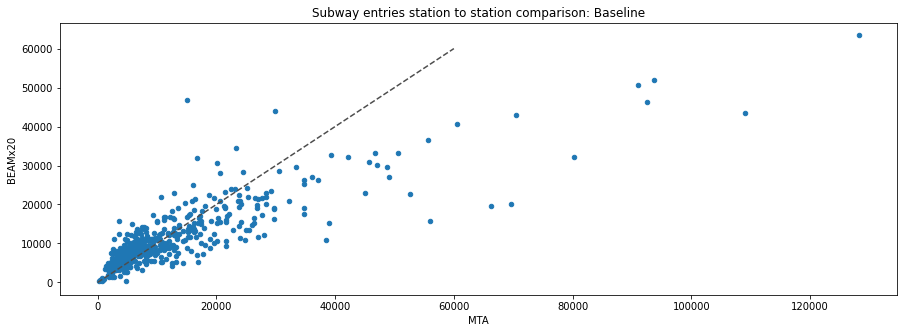

In [ ]:
#@title Subway vs MTA scatter
base_ent = to_entries_on_station(s3url, iteration)
subway_mta_comparison(base_ent, 'Baseline')

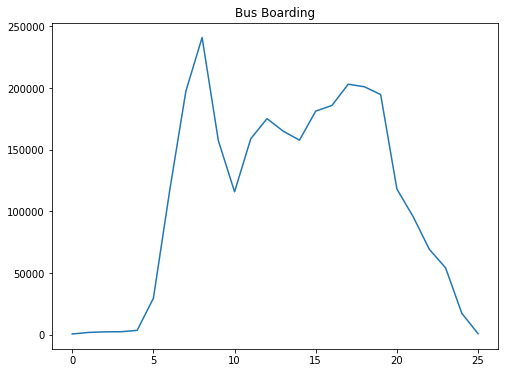

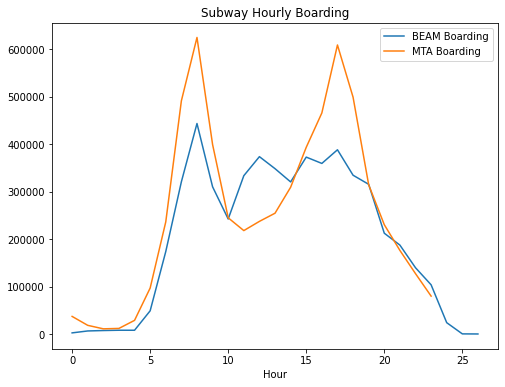

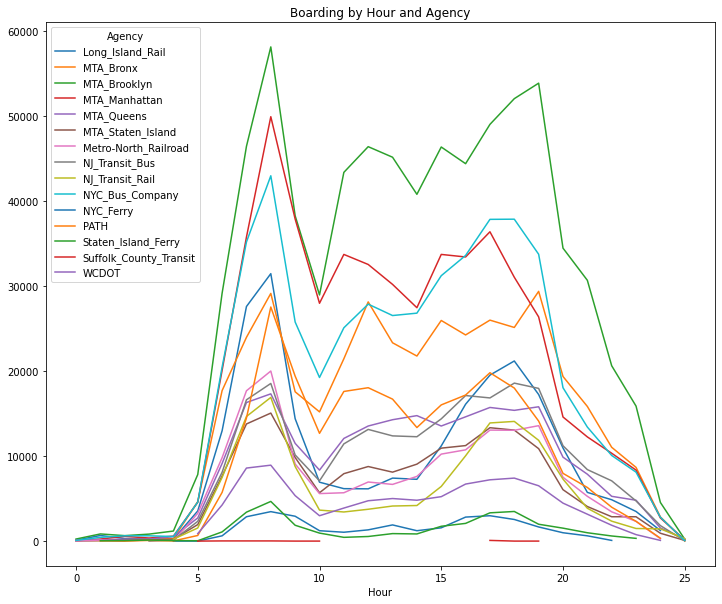

In [ ]:
#@title Boarding by hour and agency

def load_events_for_hour_and_agency(s3url, iteration):
  s3path = get_output_path_from_s3_url(s3url)

  events_file_path = "{0}/ITERS/it.{1}/{1}.events.csv.gz".format(s3path, iteration)
  columns = ['type', 'person', 'vehicle', 'vehicleType', 'mode', 'time', 'driver']
  schema = {'type':str, 'person':str, 'vehicle':str, 'vehicleType':str, 'mode':str, 'time':int, 'driver':str}
  events = pd.concat([df[(df['type'] == 'PersonEntersVehicle') | (df['type'] == 'PathTraversal')]
                    for df in pd.read_csv(events_file_path, chunksize=100000, low_memory=False, dtype=schema, usecols=schema)])
  
  return events

# need events loaded with load_events_for_hour_and_agency
def plot_by_hour_and_agency(ev):

  pt = ev[ev['type'] == 'PathTraversal']
  vehicle_to_mode = pt[['vehicle', 'mode']].drop_duplicates()

  pev = ev[ev['type'] == 'PersonEntersVehicle'][['person', 'time', 'type', 'vehicle']]
  pev = pd.merge(pev, vehicle_to_mode, how='left', on='vehicle')

  boarding = pev.copy()
  boarding['prev_vehicle'] = boarding.groupby('person')['vehicle'].shift(1)
  boarding = boarding[~boarding['mode'].isin(['walk', 'car', 'bike'])]
  boarding = boarding[~boarding['person'].str.startswith('TransitDriverAgent', na=False)]
  boarding = boarding[~((boarding['mode'] == 'subway') & (boarding['vehicle'].str.contains('Subway')) & (boarding['prev_vehicle'].str.contains('Subway', na=False)))]
  boarding = boarding.drop(columns='prev_vehicle')

  entries = boarding.groupby(['vehicle', 'time', 'mode'])['person'].count()
  entries = entries.reset_index(name = 'entries')

  def extractAgency(row):
    import re
    ag_str = row['vehicle'].split(":")[0]
    if ag_str == '151_631':
      return "PATH"
    else:
      return re.sub("_20\d+", "", ag_str)

  entries['Hour'] = entries['time'] // 3600
  entries['Agency'] = entries.apply(extractAgency, axis=1)
  data = entries.groupby(['Agency', 'Hour'])['entries'].sum().reset_index()
  data = data.pivot(index='Hour', columns=['Agency'], values='entries')

  #preparing mta data
  mta_sub = pd.read_csv("https://beam-outputs.s3.amazonaws.com/new_city/newyork/hourly-boardings-station-mta.csv.gz")
  hour_headers = [str(x) for x in range(1, 25)]
  mta_sub = mta_sub[hour_headers].sum().reset_index(drop=True)
  mta_sub.name = "MTA Boarding"


  #plotting
  # fig, axs = plt.subplots(1, 3, figsize=(21,5))
  # fig.tight_layout(pad=0.1)
  # fig.subplots_adjust(wspace=0.25, hspace=0.1)
  # fig.suptitle("Boarding by Hour and Agency")
  # fig.subplots_adjust(top=0.91)



  fsize=(8,6)
  #plot bus
  bus_data = entries.groupby(['mode', 'Hour'])['entries'].sum().reset_index()
  bus_data = bus_data[bus_data['mode'] == 'bus']
  bus_data = bus_data['entries'] * 20
  bus_data.plot(figsize=fsize, title='Bus Boarding');

  #plot subway
  data20 = data * 20
  ax1 = data20['NYC_Subway'].to_frame(name="BEAM Boarding") \
    .plot(figsize=fsize, title="Subway Hourly Boarding");
  mta_sub.plot(ax=ax1, legend=True);

  #plot agencies
  data20.drop(columns=['NYC_Subway']) \
    .plot(figsize=(12, 10), title="Boarding by Hour and Agency");

ev = load_events_for_hour_and_agency(s3url, iteration)
plot_by_hour_and_agency(ev);

events file url: https://beam-outputs.s3.amazonaws.com/output/newyork/nyc-200k-future-from-september-minus-55__2020-10-07_18-37-02_zcu/ITERS/it.10/10.events.csv.gz
loading took 159.9278962612152 seconds
events file url: https://beam-outputs.s3.amazonaws.com/output/newyork/nyc-200k-future-from-september-minus-45__2020-10-07_18-37-01_bzq/ITERS/it.10/10.events.csv.gz
loading took 173.27292394638062 seconds
events file url: https://beam-outputs.s3.amazonaws.com/output/newyork/nyc-200k-future-from-september-minus-30__2020-10-07_18-37-02_ocd/ITERS/it.10/10.events.csv.gz
loading took 170.94996547698975 seconds


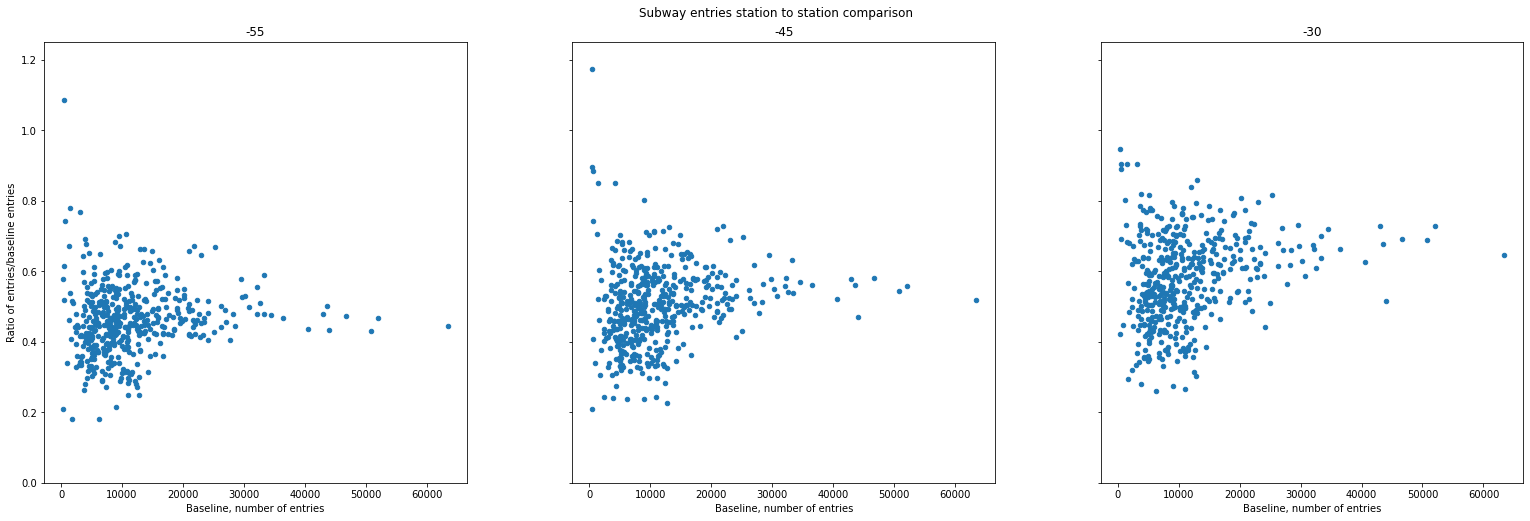

In [ ]:
#@title Baseline vs Future runs

#Future runs: must be exactly 3 urls (or comment out the subway_comparison below)
runs = [
("-55", "https://s3.us-east-2.amazonaws.com/beam-outputs/index.html#output/newyork/nyc-200k-future-from-september-minus-55__2020-10-07_18-37-02_zcu"),
("-45", "https://s3.us-east-2.amazonaws.com/beam-outputs/index.html#output/newyork/nyc-200k-future-from-september-minus-45__2020-10-07_18-37-01_bzq"),
("-30", "https://s3.us-east-2.amazonaws.com/beam-outputs/index.html#output/newyork/nyc-200k-future-from-september-minus-30__2020-10-07_18-37-02_ocd"),
]

data = [(run[0], to_entries_on_station(run[1], 10)) for run in runs]


fig, axs = plt.subplots(1, 3, sharey='all', figsize=(21,7))
fig.tight_layout(pad=0.1)
fig.subplots_adjust(wspace=0.25, hspace=0.1)
fig.suptitle("Subway entries station to station comparison")
fig.subplots_adjust(top=0.91)
subway_comparison(base_ent, data[0][1], data[0][0], axs[0])
subway_comparison(base_ent, data[1][1], data[1][0], axs[1])
subway_comparison(base_ent, data[2][1], data[2][0], axs[2])